Loading and preprocessing data...
Creating sequences...


c:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - loss: 0.1619 - val_loss: 0.0030 - learning_rate: 1.0000e-04
Epoch 2/100
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - loss: 0.0163 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 3/100
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - loss: 0.0136 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 4/100
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - loss: 0.0133 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 5/100
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - loss: 0.0123 - val_loss: 0.0016 - learning_rate: 1.0000e-04
Epoch 6/100
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - loss: 0.0106 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 7/100
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - loss: 0.0110 - val_loss: 0.0016 - learning_rate: 1.0000e-04
Epoch 8/100
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 0.0102 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 9/100
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 33s 2

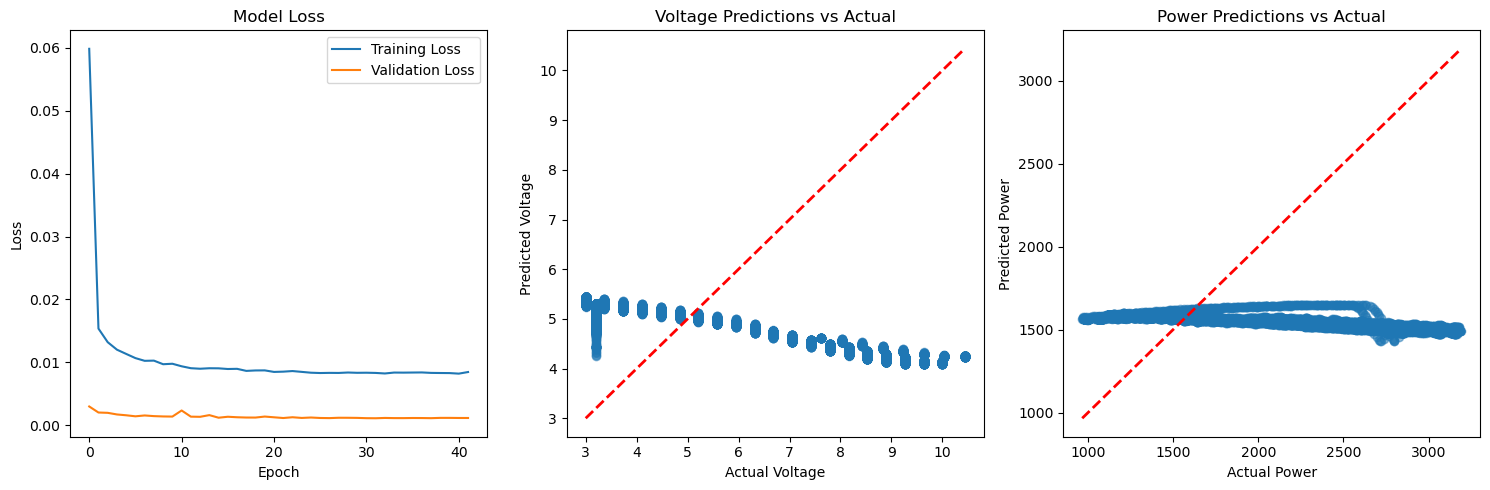

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

class PowerPredictor:
    def __init__(self, data_paths):
        self.data_paths = data_paths
        self.time_scaler = MinMaxScaler()
        self.voltage_scaler = RobustScaler()
        self.power_scaler = RobustScaler()
        self.seq_length = 20
        self.model = None

    def load_and_preprocess_data(self):
        print("Loading and preprocessing data...")
        datasets = []

        for path in self.data_paths:
            df = pd.read_csv(path)
            # Basic preprocessing
            df['datetime'] = pd.to_datetime(df['time'], unit='s')
            df['hour'] = df['datetime'].dt.hour
            df['day'] = df['datetime'].dt.day

            # Periodic time features
            df['time_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
            df['time_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

            # Scale features
            df['voltage_scaled'] = self.voltage_scaler.fit_transform(df[['input_voltage']])
            df['power_scaled'] = self.power_scaler.fit_transform(df[['el_power']])

            # Apply np.clip to limit extreme values
            df['voltage_scaled'] = np.clip(df['voltage_scaled'], -3, 3)
            df['power_scaled'] = np.clip(df['power_scaled'], -3, 3)

            # Rolling statistics
            window = 24
            df['voltage_rolling_mean'] = df['voltage_scaled'].rolling(window=window, min_periods=1).mean()
            df['power_rolling_mean'] = df['power_scaled'].rolling(window=window, min_periods=1).mean()
            df['voltage_rolling_std'] = df['voltage_scaled'].rolling(window=window, min_periods=1).std()
            df['power_rolling_std'] = df['power_scaled'].rolling(window=window, min_periods=1).std()

            # Drop rows with NaN values after preprocessing
            df.dropna(inplace=True)

            datasets.append(df)

        self.data = pd.concat(datasets, ignore_index=True)

        # Feature selection
        self.features = [
            'voltage_scaled', 'power_scaled',
            'time_sin', 'time_cos',
            'voltage_rolling_mean', 'power_rolling_mean',
            'voltage_rolling_std', 'power_rolling_std'
        ]

        # Check for NaN and infinite values in data
        if self.data[self.features].isnull().values.any():
            print("Warning: Data contains NaN values after preprocessing.")
        if np.isinf(self.data[self.features].values).any():
            print("Warning: Data contains infinite values after preprocessing.")
        
        return self.data[self.features].values

    def create_sequences(self, data):
        print("Creating sequences...")
        sequences = []
        targets = []

        for i in range(len(data) - self.seq_length):
            seq = data[i:(i + self.seq_length)]
            target = data[i + self.seq_length, :2]  # Only voltage and power as targets
            sequences.append(seq)
            targets.append(target)

        sequences = np.array(sequences)
        targets = np.array(targets)

        # Check for NaN values in sequences and targets
        if np.isnan(sequences).any() or np.isnan(targets).any():
            print("Warning: Sequences contain NaN values after creation.")
            # Remove any sequences with NaN
            mask = ~np.isnan(sequences).any(axis=(1, 2))
            sequences = sequences[mask]
            targets = targets[mask]

        return sequences, targets

    def build_model(self, input_shape):
        model = Sequential()
        model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))
        model.add(LSTM(50, activation='tanh'))
        model.add(Dropout(0.2))
        model.add(Dense(2, activation='linear'))  # output 2 (voltage, power)

        model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
        return model

    def train_model(self, X_train, y_train, X_val, y_val):
        input_shape = (X_train.shape[1], X_train.shape[2])
        self.model = self.build_model(input_shape)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        model_checkpoint = ModelCheckpoint('best_power_model.keras', save_best_only=True)

        history = self.model.fit(
            X_train, y_train, epochs=100, batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, reduce_lr, model_checkpoint]
        )

        return history

    def evaluate_model(self, X_test, y_test):
        print("\nEvaluating model performance...")

        # Load the saved model
        self.model = self.build_model(X_test.shape[1:])

        # Make predictions on the test data
        predictions = self.model.predict(X_test)

        # Inverse transform predictions
        pred_voltage = self.voltage_scaler.inverse_transform(predictions[:, 0].reshape(-1, 1))
        pred_power = self.power_scaler.inverse_transform(predictions[:, 1].reshape(-1, 1))

        actual_voltage = self.voltage_scaler.inverse_transform(y_test[:, 0].reshape(-1, 1))
        actual_power = self.power_scaler.inverse_transform(y_test[:, 1].reshape(-1, 1))

        # Calculate metrics
        voltage_mse = mean_squared_error(actual_voltage, pred_voltage)
        voltage_mae = mean_absolute_error(actual_voltage, pred_voltage)
        power_mse = mean_squared_error(actual_power, pred_power)
        power_mae = mean_absolute_error(actual_power, pred_power)

        print("\nVoltage Metrics:")
        print(f"MSE: {voltage_mse:.4f}")
        print(f"MAE: {voltage_mae:.4f}")
        print("\nPower Metrics:")
        print(f"MSE: {power_mse:.4f}")
        print(f"MAE: {power_mae:.4f}")

        return pred_voltage, pred_power, actual_voltage, actual_power

    def plot_results(self, history, pred_voltage, pred_power, actual_voltage, actual_power):
        print("Plotting results...")
        # Training history
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Voltage predictions
        plt.subplot(132)
        plt.scatter(actual_voltage, pred_voltage, alpha=0.5)
        plt.plot([actual_voltage.min(), actual_voltage.max()], 
                [actual_voltage.min(), actual_voltage.max()], 'r--', lw=2)
        plt.title('Voltage Predictions vs Actual')
        plt.xlabel('Actual Voltage')
        plt.ylabel('Predicted Voltage')
        
        # Power predictions
        plt.subplot(133)
        plt.scatter(actual_power, pred_power, alpha=0.5)
        plt.plot([actual_power.min(), actual_power.max()], 
                [actual_power.min(), actual_power.max()], 'r--', lw=2)
        plt.title('Power Predictions vs Actual')
        plt.xlabel('Actual Power')
        plt.ylabel('Predicted Power')
        
        plt.tight_layout()
        plt.show()

    def train_and_evaluate(self):
        # Load and preprocess data
        data = self.load_and_preprocess_data()

        # Create sequences
        X, y = self.create_sequences(data)

        # Split data
        train_size = int(0.8 * len(X))
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # Train model
        history = self.train_model(X_train, y_train, X_test, y_test)

        # Evaluate
        pred_voltage, pred_power, actual_voltage, actual_power = self.evaluate_model(X_test, y_test)

        # Plot results
        self.plot_results(history, pred_voltage, pred_power, actual_voltage, actual_power)

# Example usage
data_paths = [
        r"C:\Users\HP\Documents\data mining\uts-uas\train\ex_1.csv",
        r"C:\Users\HP\Documents\data mining\uts-uas\train\ex_9.csv",
        r"C:\Users\HP\Documents\data mining\uts-uas\train\ex_20.csv",
        r"C:\Users\HP\Documents\data mining\uts-uas\train\ex_21.csv",
        r"C:\Users\HP\Documents\data mining\uts-uas\train\ex_23.csv",
        r"C:\Users\HP\Documents\data mining\uts-uas\train\ex_24.csv"
]

predictor = PowerPredictor(data_paths)
predictor.train_and_evaluate()
